In [1]:
pip install pyod

     |████████████████████████████████| 111 kB 7.3 MB/s 
  Created wheel for pyod: filename=pyod-0.9.4-py3-none-any.whl size=130726 sha256=e9a99e7fbc19fe6c648f861fd41bdebcc6c1b3b86b7cbb7bb5d9ac63ce543ad4
  Stored in directory: /root/.cache/pip/wheels/50/32/84/d64079e8bf087c1b231c9beecfa9abc08592ab5f5f333124cd
Successfully built pyod


In [4]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.font_manager 

from pyod.models.abod import ABOD
from pyod.models.cblof import CBLOF
from pyod.models.hbos import HBOS

In [6]:
df = pd.read_csv("BigMart.csv")

In [7]:
df.head()

,Item_Identifier,Item_Weight,Item_Fat_Content,Item_Visibility,Item_Type,Item_MRP,Outlet_Identifier,Outlet_Establishment_Year,Outlet_Size,Outlet_Location_Type,Outlet_Type,Item_Outlet_Sales
0,FDA15,9.30,Low Fat,0.016047,Dairy,249.8092,OUT049,1999,Medium,Tier 1,Supermarket Type1,3735.1380
1,DRC01,5.92,Regular,0.019278,Soft Drinks,48.2692,OUT018,2009,Medium,Tier 3,Supermarket Type2,443.4228
2,FDN15,17.50,Low Fat,0.016760,Meat,141.6180,OUT049,1999,Medium,Tier 1,Supermarket Type1,2097.2700
3,FDX07,19.20,Regular,0.000000,Fruits and Vegetables,182.0950,OUT010,1998,NaN,Tier 3,Grocery Store,732.3800
4,NCD19,8.93,Low Fat,0.000000,Household,53.8614,OUT013,1987,High,Tier 3,Supermarket Type1,994.7052


In [8]:
df.shape

(8523, 12)

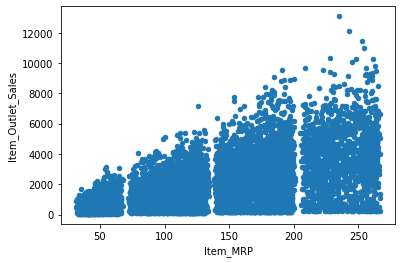

In [9]:
df.plot.scatter('Item_MRP', 'Item_Outlet_Sales')

In [10]:
#Normalising 
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler(feature_range = (0,1))
df[['Item_MRP', 'Item_Outlet_Sales']] = scaler.fit_transform(df[['Item_MRP', 'Item_Outlet_Sales']])

In [15]:
f1 = df['Item_MRP'].values
f1

array([0.92750715, 0.0720684 , 0.46828841, ..., 0.22849221, 0.30493925,
       0.18750976])

In [16]:
f1 = f1.reshape(-1, 1)

In [17]:
f2 = df['Item_Outlet_Sales'].values
f2

array([0.28358666, 0.03141895, 0.15811486, ..., 0.08885035, 0.13883505,
       0.05610527])

In [18]:
f2 = f2.reshape(-1, 1)

In [25]:
f = np.concatenate((f1, f2), axis = 1)

In [19]:
from pyod.models.mcd import MCD
from pyod.models.lof import LOF

In [20]:
random_state = np.random.RandomState(21)
outlier_fraction = 0.05

In [41]:
algos = {'Angle Based Outlier Detector': ABOD(contamination = outlier_fraction), 'Cluster Based Outlier Factor': CBLOF(contamination = outlier_fraction, random_state = random_state), 'Histogram Based Outlier Detection': HBOS(contamination = outlier_fraction), 'Local Outlier Factor': LOF(n_neighbors = 35, contamination = outlier_fraction), 'Minimum Covariance Determinant': MCD(contamination = outlier_fraction, random_state = random_state)}

In [42]:
x, y = np.meshgrid(np.linspace(0, 1, 200), np.linspace(0, 1, 200))

In [43]:
from scipy import stats

In [46]:
for i,(clf_name,clf) in enumerate(algos.items()):
    clf.fit(f)
    score_pred=clf.decision_function(f)*-1
    y_pred=clf.predict(f)
    n_inliers=len(y_pred)-np.count_nonzero(y_pred)
    n_outliers=np.count_nonzero(y_pred)
 
    plt.figure(figsize=(8,8))
    
    dfx=df
    dfx['outlier']=y_pred.tolist()
 
    ix1=np.array(dfx['Item_MRP'][dfx['outlier']==0]).reshape(-1,1)
    ix2=np.array(dfx['Item_Outlet_Sales'][dfx['outlier']==0]).reshape(-1,1)
 
    ox1=np.array(dfx['Item_MRP'][dfx['outlier']==1]).reshape(-1,1)
    ox2=np.array(dfx['Item_Outlet_Sales'][dfx['outlier']==1]).reshape(-1,1)

    print('OUTLIERS : ', n_outliers,'INLIERS : ', n_inliers, clf_name)
 
    threshold= stats.scoreatpercentile(score_pred,100*outlier_fraction)

OUTLIERS :  447 INLIERS :  8076 Angle Based Outlier Detector
OUTLIERS :  427 INLIERS :  8096 Cluster Based Outlier Factor
OUTLIERS :  501 INLIERS :  8022 Histogram Based Outlier Detection
OUTLIERS :  392 INLIERS :  8131 Local Outlier Factor
OUTLIERS :  427 INLIERS :  8096 Minimum Covariance Determinant


<Figure size 576x576 with 0 Axes>

<Figure size 576x576 with 0 Axes>

<Figure size 576x576 with 0 Axes>

<Figure size 576x576 with 0 Axes>

<Figure size 576x576 with 0 Axes>

Text(0.5, 1.0, 'Minimum Covariance Determinant')

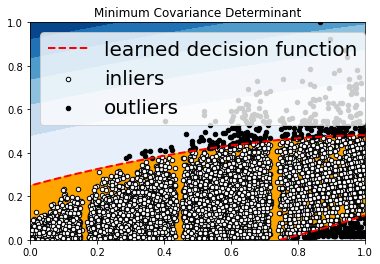

In [47]:
Z = clf.decision_function(np.c_[x.ravel(), y.ravel()])*- 1
Z = Z.reshape(x.shape)
plt.contourf(x, y, Z, levels = np.linspace(Z.min(), threshold,7),cmap = plt.cm.Blues_r)
a = plt.contour(x,y,Z, levels=[threshold], linewidths=2, colors = 'red')
 
plt.contourf(x, y, Z, levels = [threshold,Z.max()], colors = 'orange')
 
b=plt.scatter(ix1,ix2, c='white', s=20,edgecolor='k')
 
c=plt.scatter(ox1,ox2, c='black', s=20,edgecolor='k')
 
plt.axis('tight')
 
plt.legend([a.collections[0],b,c],['learned decision function', 'inliers', 'outliers'], prop=matplotlib.font_manager.FontProperties(size=20), loc=2)
plt.xlim((0,1))
plt.ylim((0,1))
plt.title(clf_name)